In [7]:
import sklearn 
from sklearn.model_selection import train_test_split #train/test split 
from sklearn import preprocessing #Preprocessing of data 
from sklearn.preprocessing import StandardScaler #Scaler
from sklearn.decomposition import PCA #PCA
from sklearn.svm import SVC #Model
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
from sklearn.metrics import confusion_matrix #Metrics 
from sklearn.metrics import f1_score 
from sklearn.model_selection import cross_val_score #Cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score #ROC curve 
from sklearn.metrics import roc_curve, auc

RANDOM_SEED = 1

np.random.seed(RANDOM_SEED)


In [8]:
#CSV read 
nRowsRead = None #Number of lines the dataframe reads. In case of wanting you read certain lines, write number. If not, 'None'.
df = pd.read_csv("Path-to-csv", delimiter=',', nrows = nRowsRead)
df.dataframeName = 'Dyt-desktop.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns') 

There are 3644 rows and 197 columns


In [9]:
#Balancing data 
NDys_df= df[df['Dyslexia']==0] #3252 samples with 196 features
Dys_df= df[df['Dyslexia']==1] #392 samples with 196 features
dys_tot, _ = Dys_df.shape
N_NDys= NDys_df.sample(dys_tot)
df= pd.merge(N_NDys, Dys_df, how='outer')


In [10]:
#Train/Test split 
y_axis= df.iloc[:,[-1]]
y= y_axis.to_numpy().flatten() #Labels (class 0 and 1)
X_axis= df.drop(y_axis.columns,axis = 1)
X= X_axis.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [11]:
#Preprocessing data 
scaler= StandardScaler()
scaler.fit(X_train) 
X_train= scaler.fit_transform(X_train)
print('Transformed shape:{}'.format(X_train.shape))
X_test= scaler.transform(X_test)
X_val= scaler.transform(X_val)

# PCA 
# pca= PCA(n_components='mle', whiten=True)
# X_train= pca.fit_transform(X_train)
# X_test= pca.transform(X_test) 
# X_val= pca.transform(X_val)


Transformed shape:(501, 196)


In [12]:
#Cross-validation recall

C_list= np.logspace(-6, 4, 11)
gamma_list= np.logspace(-6, 4, 11)
components_list= np.round(np.linspace(start=1, stop=196, num=11)).astype(int)
recall = np.zeros((len(C_list), len(gamma_list), len(components_list)))


for i in range(len(C_list)):
     for j in range(len(gamma_list)):
          for k in range(len(components_list)):
               pca= PCA(n_components=components_list[k], whiten=True)
               X_train_pca= pca.fit_transform(X_train)
               X_test_pca= pca.transform(X_test)
               X_val_pca= pca.transform(X_val)
               svc= SVC(C=C_list[i], gamma=gamma_list[j], kernel='rbf')
               svc.fit(X_train_pca, y_train)
               y_pred= svc.predict(X_val_pca)
               tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
               recall[i, j, k] = float(tp) / (tp + fn)
               


index_max = np.unravel_index(np.argmax(recall), recall.shape)

print('Max. recall:{}'.format(recall[index_max]))
C_opt = C_list[index_max[0]]
gamma_opt = gamma_list[index_max[1]]
comp_opt= components_list[index_max[2]]
print('Optimal number of components:{}'.format(comp_opt))
print('Optimal C: {}'.format(C_opt))
print('Optimal gamma:{}'.format(gamma_opt))

Max. recall:0.8245614035087719
Optimal number of components:40
Optimal C: 1000.0
Optimal gamma:1e-06


In [13]:
#Cross-validation of C and gamma (recall)
puntos = 11

gamma_list_1= np.linspace(start=gamma_opt/10, stop=gamma_opt*2, num=puntos*2)
C_list_1=np.linspace(start=C_opt-(C_opt/2), stop=C_opt+(C_opt/2), num=puntos)
compt_list_1= np.round(np.linspace(start=1, stop=196, num=puntos)).astype(int)
recall = np.zeros((len(C_list_1), len(gamma_list_1), len(compt_list_1)))

for i in range(len(C_list_1)):
     for j in range(len(gamma_list_1)):
               for k in range(len(compt_list_1)):
                     pca= PCA(n_components=compt_list_1[k], whiten=True)
                     X_train_pca= pca.fit_transform(X_train)
                     X_test_pca= pca.transform(X_test)
                     X_val_pca= pca.transform(X_val)
                     svc= SVC(C=C_list_1[i], gamma=gamma_list_1[j], kernel='rbf')
                     svc.fit(X_train_pca, y_train)
                     tn, fp, fn, tp = confusion_matrix(y_val, svc.predict(X_val_pca)).ravel()
                     recall[i, j, k] = float(tp) / (tp + fn)

index_max = np.unravel_index(np.argmax(recall), recall.shape)

print('Max. Recall:{}'.format(recall[index_max]))
gamma_opt_1 = gamma_list_1[index_max[1]]
c_opt_1= C_list_1[index_max[0]]
compt_opt_1= compt_list_1[index_max[2]]
print('Optimal C: {}'.format(c_opt_1))
print('Optimal gamma:{}'.format(gamma_opt_1))
print('Optimal number of components:{}'.format(compt_opt_1))
print(index_max)

Max. Recall:0.8771929824561403
Optimal C: 600.0
Optimal gamma:1.6380952380952382e-06
Optimal number of components:20
(1, 17, 1)


In [14]:
#Cross-validation (f1)
C_list2 = np.logspace(-6, 4, 11)
gamma_list2 = np.logspace(-6, 4, 11)
components_list2= np.round(np.linspace(start=1, stop=196, num=11)).astype(int)
f1_max = np.zeros((len(C_list2), len(gamma_list2), len(components_list2)))

for i in range(len(C_list2)):
    for j in range(len(gamma_list2)):
        for k in range(len(components_list2)):
            pca = PCA(n_components=components_list2[k], whiten=True)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)
            X_val_pca = pca.transform(X_val)
            svc = SVC(C=C_list2[i], gamma=gamma_list2[j], kernel='rbf')
            svc.fit(X_train_pca, y_train)
            y_pred = svc.predict(X_val_pca)
            tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
            f1score_value = f1_score(y_val, y_pred)
            f1_max[i, j, k] = f1score_value
    

index_max_2 = np.unravel_index(np.argmax(f1_max), f1_max.shape)
gamma_opt_2 = gamma_list2[index_max_2[1]]
c_opt_2= C_list2[index_max_2[0]]
compt_opt_2= components_list2[index_max_2[2]]
           
print('Max. F1: {}'.format(f1_max[index_max_2]))
print('Optimal number of components: {}'.format(compt_opt_2))
print('Optimal C: {}'.format(c_opt_2))
print('Optimal gamma: {}'.format(gamma_opt_2))


Max. F1: 0.7479674796747967
Optimal number of components: 60
Optimal C: 1000.0
Optimal gamma: 1e-06


In [15]:
#Validation of model (recall)

kf = KFold(n_splits=10, shuffle=True)
scores = [] 
for train_idx, val_idx in kf.split(X):
    X_train_k, y_train_k = X[train_idx], y[train_idx]
    X_val_k, y_val_k = X[val_idx], y[val_idx]
    pca= PCA(n_components=compt_opt_1, whiten=True)
    X_train_pca= pca.fit_transform(X_train_k)
    X_val_pca= pca.transform(X_val_k)
    svc= SVC(C=c_opt_1, gamma=gamma_opt_1, kernel='rbf', class_weight='balanced')
    svc.fit(X_train_pca, y_train_k)
    y_pred_k= svc.predict(X_val_pca)
    cm= confusion_matrix(y_val_k, y_pred_k)
    tn, fp, fn, tp = confusion_matrix(y_val_k, y_pred_k).ravel()
    recall_v = float(tp) / (tp + fn)
    scores.append(recall_v)

print('Recall mean: {}'.format(np.mean(scores))) 
print('Recall standard deviation: {}'.format(np.std(scores)))


Recall mean: 0.9689966243992909
Recall standard deviation: 0.014981105583152406


In [16]:
#Validation of final model (F1)

kf = KFold(n_splits=10, shuffle=True)
scores = [] 
scores_f1= []
for train_idx, val_idx in kf.split(X):
    X_train_k, y_train_k = X[train_idx], y[train_idx]
    X_val_k, y_val_k = X[val_idx], y[val_idx]
    pca= PCA(n_components=compt_opt_2, whiten=True)
    X_train_pca= pca.fit_transform(X_train_k)
    X_val_pca= pca.transform(X_val_k)
    svc= SVC(C=c_opt_2, gamma=gamma_opt_2, kernel='rbf', class_weight='balanced')
    svc.fit(X_train_pca, y_train_k)
    y_pred_k= svc.predict(X_val_pca)
    cm= confusion_matrix(y_val_k, y_pred_k)
    tn, fp, fn, tp = confusion_matrix(y_val_k, y_pred_k).ravel()
    recall_v = float(tp) / (tp + fn)
    f1sco= f1_score(y_pred_k, y_val_k)
    scores.append(recall_v)
    scores_f1.append(f1sco)

print('F1 score mean:{}'.format(np.mean(scores_f1)))
print('Recall mean: {}'.format(np.mean(scores))) 
print('Recall standard deviation: {}'.format(np.std(scores)))

F1 score mean:0.6471314068890079
Recall mean: 0.7817918877521451
Recall standard deviation: 0.03722071912385248


In [17]:
#Final model (Recall)

pca= PCA(n_components=compt_opt_1, whiten=True)
X_train_pca= pca.fit_transform(X_train)
X_test_pca= pca.transform(X_test)
X_val_pca= pca.transform(X_val)
svc= SVC(C=c_opt_1, gamma=gamma_opt_1, kernel='rbf', class_weight='balanced')
svc.fit(X_train_pca, y_train)
y_pred= svc.predict(X_test_pca)
cm= confusion_matrix(y_test, y_pred)
print(cm)


tn, fp, fn, tp = cm.ravel()
recall= float(tp) / (tp + fn)
print('Recall:{}'.format(recall))
f1= f1_score(y_test, y_pred)
print('F1 score:{}'.format(f1))


[[42 28]
 [21 66]]
Recall:0.7586206896551724
F1 score:0.729281767955801


In [18]:
#Final model (F1)
pca= PCA(n_components=compt_opt_2, whiten=True)
X_train_pca= pca.fit_transform(X_train)
X_test_pca= pca.transform(X_test)
X_val_pca= pca.transform(X_val)
svc= SVC(C=c_opt_2, gamma=gamma_opt_2, kernel='rbf', class_weight='balanced')
svc.fit(X_train_pca, y_train)
y_pred= svc.predict(X_test_pca)
cm= confusion_matrix(y_test, y_pred)
report= classification_report(y_test, y_pred)
print(cm)
print(report)

tn, fp, fn, tp = cm.ravel()
recall= float(tp) / (tp + fn)
print('Recall:{}'.format(recall))
f1= f1_score(y_test, y_pred)
print('F1 score:{}'.format(f1))


[[44 26]
 [21 66]]
              precision    recall  f1-score   support

           0       0.68      0.63      0.65        70
           1       0.72      0.76      0.74        87

    accuracy                           0.70       157
   macro avg       0.70      0.69      0.69       157
weighted avg       0.70      0.70      0.70       157

Recall:0.7586206896551724
F1 score:0.7374301675977654


ROC curve with best recall parameters


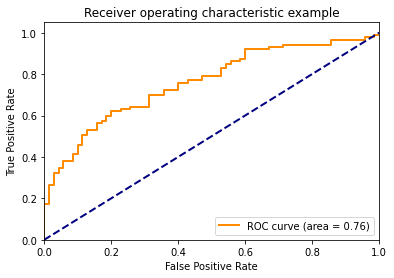

ROC curve with best F1 parameters


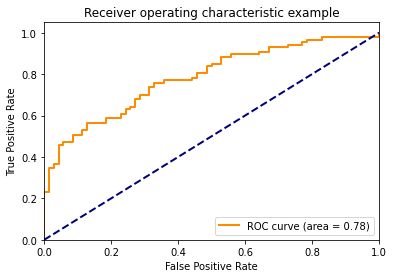

In [22]:
#ROC curve with recall-centered model 
pca= PCA(n_components=compt_opt_1, whiten=True)
X_train_pca= pca.fit_transform(X_train)
X_test_pca= pca.transform(X_test)
X_val_pca= pca.transform(X_val)
model1= SVC(C=c_opt_1, gamma=gamma_opt_1, kernel='rbf', class_weight='balanced')
model1.fit(X_train_pca, y_train)
y_score= model1.decision_function(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_score, drop_intermediate=True)
roc_auc = auc(fpr, tpr)
print('ROC curve with best recall parameters')
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc_svc_2.png')
plt.show()


#ROC curve with F1-centered model 
pca= PCA(n_components=compt_opt_2, whiten=True)
X_train_pca= pca.fit_transform(X_train)
X_test_pca= pca.transform(X_test)
X_val_pca= pca.transform(X_val)
model2= SVC(C=c_opt_2, gamma=gamma_opt_2, kernel='rbf', class_weight='balanced')
model2.fit(X_train_pca, y_train)
y_score1= model2.decision_function(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_score1, drop_intermediate=True)
roc_auc = auc(fpr, tpr)
print('ROC curve with best F1 parameters')
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc_svc_f1.png')
plt.show()

In [20]:
#dict= {'y_score': y_score, 'y_test': y_test}
#df_o= pd.DataFrame.from_dict(dict)
#df_o.to_csv('svc_results_2.csv')